## Load necessary modules

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
#from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


## Load RetinaNet model

In [2]:
# adjust this to point to your downloaded/trained model
model_path = os.path.join('..', 'snapshots', 'resnet50_coco_best_v2.1.0.h5')

# load retinanet model
#model = keras.models.load_model(model_path, custom_objects=custom_objects)
model = models.load_model(model_path, backbone_name='resnet50')
#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Run detection on example

processing time:  5.958775043487549


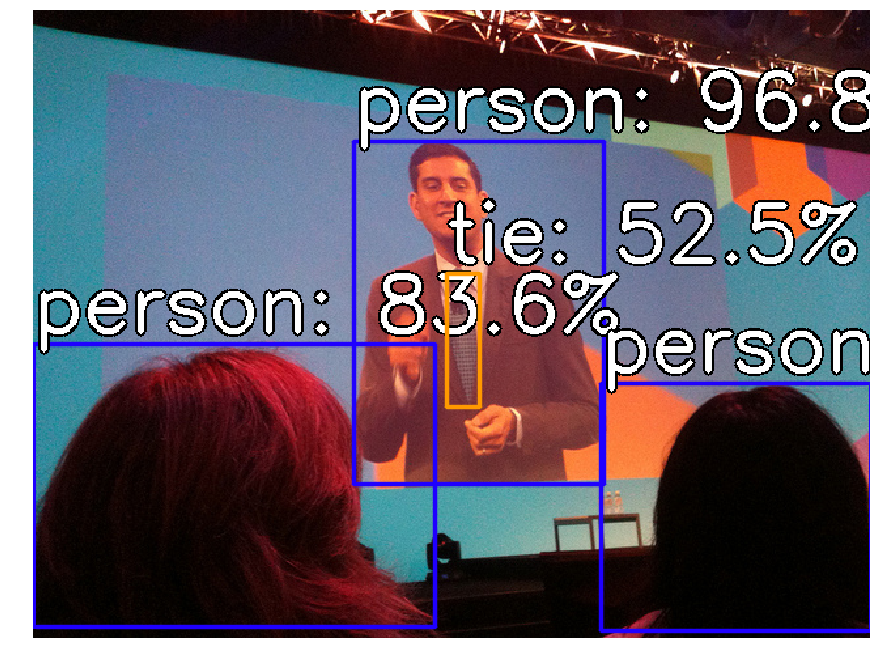

In [10]:
# load image
image = read_image_bgr('000000008021.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
   
   # caption = "{} {:.3f}".format(labels_to_names[label], score)
    caption = "%s: %.1f%%"%(labels_to_names[label], score*100)
    #draw_caption(draw, b, caption)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 7)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [4]:
import colorsys
import random
N = len(labels_to_names)
HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
RGB_tuples = list(map(lambda x: tuple(255*np.array(colorsys.hsv_to_rgb(*x))), HSV_tuples))
random.shuffle(RGB_tuples)

In [ ]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.physical_device_desc for x in local_device_protos if x.device_type == 'GPU']

GPU = get_available_gpus()[-1][17:33]
print(GPU)


In [11]:
cap = cv2.VideoCapture('/Users/yuanyuan.han/kaggle/keras-retinanet-master/examples/road.mp4')

counter = 0
sum_time=0
while(True):
    ret, draw = cap.read()
    if not ret:
        break
    bgr = cv2.cvtColor(draw, cv2.COLOR_RGB2BGR)
    
    # preprocess image for network
    image = preprocess_image(bgr)
    image, scale = resize_image(image)
    
    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)
    t=time.time() - start

    # correct for image scale
    boxes /= scale
    
    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
       # scores are sorted so we can break
            if score < 0.5:
               break
            color = label_color(label)
            b = box.astype(int)
            draw_box(draw, b, color=color)
            #caption = "{} {:.3f}".format(labels_to_names[label], score)
            caption = "%s: %.1f%%"%(labels_to_names[label], score*100)
            #draw_caption(draw, b, caption)     
            cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 7)
            cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)
            if sum_time>0:
                #cv2.putText(draw, "%s Processing time %.2fs (%.1ffps)  AVG %.2fs (%.1ffps)"%(GPU, t,1.0/t,sum_time/counter,counter/sum_time), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 7)
                #cv2.putText(draw, "%s Processing time %.2fs (%.1ffps)  AVG %.2fs (%.1ffps)"%(GPU, t,1.0/t,sum_time/counter,counter/sum_time), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)
                  cv2.putText(draw, " Processing time %.2fs (%.1ffps)  AVG %.2fs (%.1ffps)"%( t,1.0/t,sum_time/counter,counter/sum_time), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 7)
                  cv2.putText(draw, " Processing time %.2fs (%.1ffps)  AVG %.2fs (%.1ffps)"%(t,1.0/t,sum_time/counter,counter/sum_time), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)
            
    cv2.imwrite('/Users/yuanyuan.han/kaggle/keras-retinanet-master/examples/image1/img%08d.jpg'%counter,draw)
    counter=counter+1
    sum_time+=t
    
cap.release()
cv2.destroyAllWindows()

processing time:  8.6231529712677
processing time:  10.01794981956482
processing time:  11.923848152160645
processing time:  11.029377937316895
processing time:  11.726349115371704
processing time:  9.322005987167358
processing time:  7.84106183052063
processing time:  7.68991494178772
processing time:  7.534549951553345
processing time:  7.48326301574707
processing time:  7.8009021282196045
processing time:  7.802464962005615
processing time:  7.44237494468689
processing time:  7.509705066680908
processing time:  7.8498289585113525
processing time:  7.765048027038574
processing time:  7.363497018814087
processing time:  7.477694034576416
processing time:  7.753874063491821
processing time:  7.7227489948272705
processing time:  7.316162824630737
processing time:  7.749433994293213
processing time:  7.724822044372559
processing time:  7.908244848251343
processing time:  8.459258079528809
processing time:  7.927341938018799
processing time:  7.2039101123809814
processing time:  7.2349481

processing time:  7.396446943283081
processing time:  7.44828987121582
processing time:  8.240675926208496
processing time:  8.026082038879395
processing time:  7.147011041641235
processing time:  7.949115991592407
processing time:  7.881469011306763
processing time:  8.36727499961853
processing time:  7.7208380699157715
processing time:  7.17451810836792
processing time:  7.696084976196289
processing time:  9.173688173294067
processing time:  8.611627101898193
processing time:  7.739269018173218
processing time:  8.798980951309204
processing time:  7.18724799156189
processing time:  7.159618139266968
processing time:  7.853080987930298
processing time:  7.576018810272217
processing time:  7.178899049758911
processing time:  7.255554914474487
processing time:  7.530781984329224
processing time:  7.203861951828003
processing time:  7.526245832443237
processing time:  7.180914878845215
processing time:  7.563310861587524
processing time:  7.208714008331299
processing time:  7.58392000198

processing time:  7.374519109725952
processing time:  10.456650018692017
processing time:  9.692559957504272
processing time:  10.39142918586731
processing time:  7.717213153839111
processing time:  7.6464149951934814
processing time:  7.701158046722412
processing time:  7.288416147232056
